# Modelos computacionales II
## Anel Mendiola
Proyecto - 30 mayo 2025

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix

# Conectar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Ruta al dataset
data_path = "/content/drive/MyDrive/dataset"

# Análisis de datos AED

Distribución en Training:
pituitary: 1457 imágenes
notumor: 1595 imágenes
glioma: 1321 imágenes
meningioma: 1339 imágenes


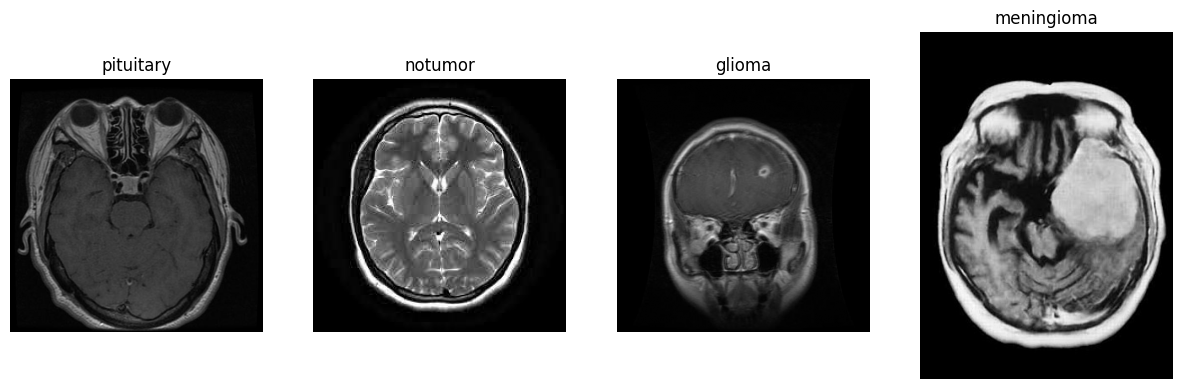

In [4]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Rutas a las carpetas
train_path = os.path.join(data_path, "Training")
test_path = os.path.join(data_path, "Testing")

# Contar imágenes en Training
classes = os.listdir(train_path)
print("Distribución en Training:")
for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(train_path, cls)))} imágenes")

# Visualizar una imagen de cada clase
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i, cls in enumerate(classes):
    img_name = os.listdir(os.path.join(train_path, cls))[0]
    img_path = os.path.join(train_path, cls, img_name)
    img = Image.open(img_path)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(cls)
    axes[i].axis('off')
plt.show()

# Identificamos el tipo de problema
En este caso el problema parece que es de clasificación ya que las variables del dataset son categóricas, por lo tanto, creo que podría realizarse una clasificación de imágenes basándome en las etiquetas de las 4 posibles clases:

1. glioma tumor
2. meningioma tumor
3. no tumor
4. pituitary tumor

# Propuesta de modelo

Ya que las carpetas están divididas en test y en train y cada una tiene subfolders que clasifican cada clase, usaré "ImageDataGenerator" de Keras para cargar las imágenes de manera estructurada y haré un análisis con CNN

In [5]:
# Ruta base
train_dir = "/content/drive/MyDrive/dataset/Training"
test_dir = "/content/drive/MyDrive/dataset/Testing"

# Normalización y aumento
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(train_dir, target_size=(150, 150), class_mode='categorical', batch_size=32)

Found 5712 images belonging to 4 classes.


In [6]:
# Contar imágenes por clase en entrenamiento
for category in os.listdir(train_dir):
    category_path = os.path.join(train_dir, category)
    print(f"{category}: {len(os.listdir(category_path))} imágenes")

pituitary: 1457 imágenes
notumor: 1595 imágenes
glioma: 1321 imágenes
meningioma: 1339 imágenes


# Preprocesamiento y aumento de datos

In [7]:
img_size = (150, 150)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# Modelo CNN

In [8]:
# Crear modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento del modelo

In [9]:
# Entrenar modelo
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=test_gen
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1317s 7s/step - accuracy: 0.4929 - loss: 1.1812 - val_accuracy: 0.7216 - val_loss: 0.7302
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.7220 - loss: 0.6946 - val_accuracy: 0.7933 - val_loss: 0.5448
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.7765 - loss: 0.5375 - val_accuracy: 0.7223 - val_loss: 0.8321
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.8216 - loss: 0.4662 - val_accuracy: 0.7719 - val_loss: 0.6270
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.8469 - loss: 0.4073 - val_accuracy: 0.8307 - val_loss: 0.3967
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.8677 - loss: 0.3575 - val_accuracy: 0.8085 - val_loss: 0.4873
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.8603 - loss: 0.3650 - val_accuracy: 0.8169 - val_loss: 0.4711
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.8743 - loss: 0.3298 - val_acc

# Evaluación del desempeño del modelo

41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 554ms/step - accuracy: 0.7941 - loss: 0.4649
Accuracy en test: 0.8726


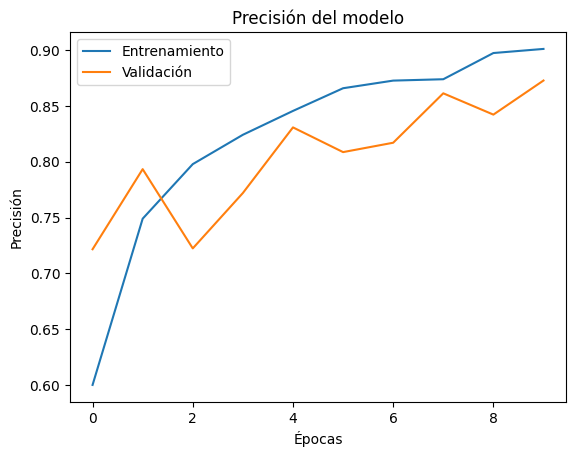

41/41 ━━━━━━━━━━━━━━━━━━━━ 25s 602ms/step

Reporte de clasificación:

              precision    recall  f1-score   support

      glioma       0.97      0.74      0.84       300
  meningioma       0.78      0.72      0.75       306
     notumor       0.86      1.00      0.92       405
   pituitary       0.90      0.98      0.94       300

    accuracy                           0.87      1311
   macro avg       0.88      0.86      0.86      1311
weighted avg       0.88      0.87      0.87      1311



In [11]:
loss, accuracy = model.evaluate(test_gen)
print(f"Accuracy en test: {accuracy:.4f}")

import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()


# Matriz de confusión y métricas
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
labels = list(test_gen.class_indices.keys())

print("\nReporte de clasificación:\n")
print(classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()))


# Matriz de confusión

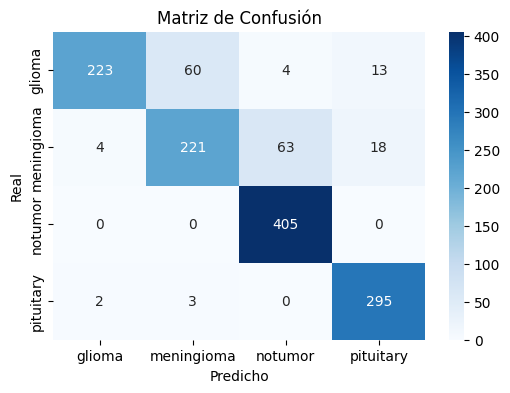

In [16]:
# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Análisis de resultados

No tumor y tumor pituitario son detectados bien con un recall alto (1.00 y 0.98), esto significa que hay pocos falsos negativos.

* F1 score es alto en todas las clases, especialmente en los tumores de pituitaria y en no tumor
* la accuracy general es alta -> 87.26%
* los gliomas tienen un recall bajo a pesar de que tiene una precisión alta, esto indica que cada que se predice un glioma, casi siempre acierta, pero genera muchos falsos negativos

El modelo puede estar sesgado a clases más fáciles de detectar y puede indicar que requiere un mejor balance para otras clases.


Considero que el modelo tiene un desempeño bueno y confiable, podría mejorarse el recall de glioma y meningioma

# Análisis de métricas por cada clase

**Glioma**
* tiene alta precisión - 0.97
* el modelo no identifica todos los gliomas correctamente, su recall es bajo

En los gliomas hay muchos falsos negativos y se clasifican en otras clases

**Meningioma**
* las métricas están más balanceadas
* posiblemente se confunde con los gliomas

**No tumor y pituitaria**
* ambas tienen métricas altas, arriba de 0.98
* no tumor tiene un recall de 1.00, esto indica que el modelo no se equivoca cuando detecta cerebros sin tumor

# ¿Cuál es el mejor resultado posible?

La clase que mejor se identificó fue la de no tumor, es importante porque minimiza el riesgo de falsos positivos
- es importante porque evita el diagnóstico erróneo en pacientes sanos

**El mejor resultado global**

El mejor resultado global lo tiene la clase de tumores de pituitaria:
- precisión alta (0.90)
- recall alto (0.98)
- buen F1 Score (0.94)

El modelo es bueno para detectar tumores de la pituitaria

# Error en clasificación de imágenes


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix


test_dir = "/content/drive/MyDrive/dataset/Testing"

Found 1311 images belonging to 4 classes.


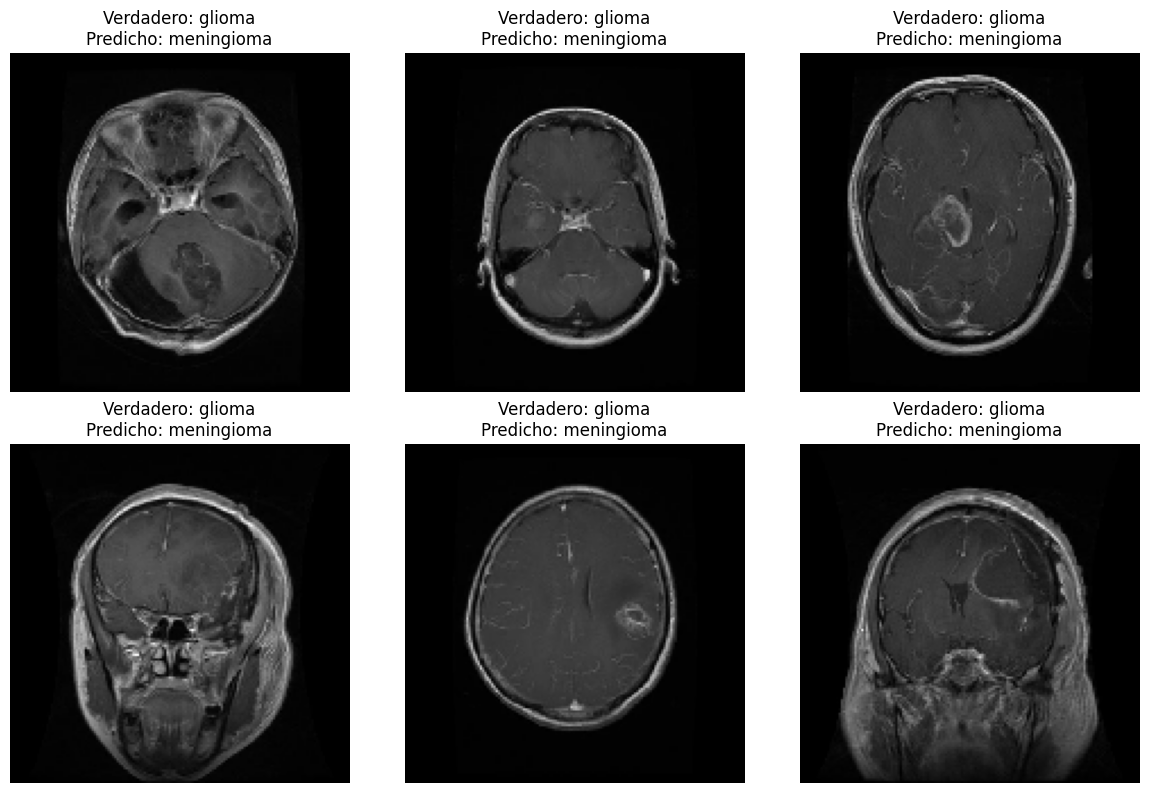

In [37]:
# configurar el generador de imágenes

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Obtener etiquetas verdaderas y nombres de archivos
y_true = test_gen.classes
filenames = test_gen.filenames

# Simular predicciones para fines de visualización (reemplaza con tus predicciones reales)
np.random.seed(42)
y_pred_classes = y_true.copy()
y_pred_classes[::13] = (y_pred_classes[::13] + 1) % 4  # simular errores

# Identificar errores
errors = np.where(y_pred_classes != y_true)[0]

# Mapeo de índices a nombres de clase
idx2label = {v: k for k, v in test_gen.class_indices.items()}

# Mostrar imágenes clasificadas erróneamente
def show_errors(indices, num=6):
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(indices[:num]):
        img_path = os.path.join(test_dir, filenames[idx])
        img = image.load_img(img_path, target_size=(150, 150))
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Verdadero: {idx2label[y_true[idx]]}\nPredicho: {idx2label[y_pred_classes[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Llamar a la función para mostrar errores
show_errors(errors, num=6)


# Análisis en errores de clasificación

- todas las imágenes mal clasificadas son gliomas que se clasifican como meningiomas

Estas confusiones pueden deberse a que las imágenes tienen formas o intensidades similares. A nivel clínico, este tipo de confusiones pueden ser críticas, los gliomas son más agresivos que los meningiomas, estos resultados pueden retrasar tratamientos apropiados en los pacientes.


# ¿Cómo mejorar el modelo?

* se puede mejorar la arquitectura del modelo CNN, pienso que podrían agregarse más capas convoluconales y agregar más filtros

* podría aumentarse el número de muestras de glioma ya que están siendo subdetectados
  - con data augmentation